In [4]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import skimage.io as skio
import sfdi_fitter.preprocess as preprocess
#import sfdi_fitter.fitter as fitter
import importlib
importlib.reload(preprocess)
#importlib.reload(fitter)


import skimage.filters as skfilt
import skimage.morphology as skmorph
import skimage.measure as skmeas
import tqdm

import sys
sys.path.append('/2tb_drive/old_data/notebooks/Boris')
import lab_tools.utils.plot_utils as pu

Populating the interactive namespace from numpy and matplotlib


In [5]:
from sfdi_fitter.preprocess import read_image,read_single_frequency,calculate_Mac,calculate_Mdc
from sfdi_fitter.preprocess import read_sfdi_stack,get_binned_stack,get_available_frequencies#,read_and_preprocess

In [6]:
import skimage.io as skio
import numpy as np
import os
import scipy.ndimage as scnd
import glob
import matplotlib.pyplot as plt


def swap_axes(stack):
    return np.swapaxes(np.swapaxes(stack,0,1),1,2)

In [7]:
%load_ext autoreload

In [8]:
def get_sample_name(sample_folder):
    return sample_folder.split('/')[-2]

def get_wavelength(sample_folder):
    return os.path.basename(sample_folder)

def calculate_real_frequencies_from_prepends(freq_prepends):
    """
    calculate real spatial frequencies k = 2pi/L from frequencies prepends
    """
    return 2*np.pi*np.array([x/160. for x in [float(x) for x in freq_prepends]])

import skimage.measure as skmeas

In [9]:
sample_folders = glob.glob('/2tb_drive/old_data/data/Hemoglobin/2022-06-08/*_*')
sample_folders_new = glob.glob('/2tb_drive/old_data/data/Hemoglobin/2022_05_10_references/*_*')

In [10]:
for wavelength in [560,630]:
    folders.extend([os.path.join(folder,str(wavelength)) for folder in sample_folders_new])

NameError: name 'folders' is not defined

In [11]:
def read_and_preprocess(sample_folder, binning_kernel_size=9, start_phase=0, verbose=True):
    """
    Preprocess sample_folder for single SFDI experiment using following steps:
     1. read all available frequencies using `get_available_frequencies(sample_folder)`
     2. calculate raw_intensities stack, Mac stack, Mdc stack
     3. do spatial binning for Mac stack for given binning_kernel_size

    :param sample_folder: (str) path to folder with single SFDI-experiment
    :param binning_kernel_size: (int) spatial binning
    :param start_phase: start_phase for read_sfdi_stack function
    :param verbose: (bool) verbosity -- plot various images including different raw_intensity values and Mac components
    :return: tuple of two:
        -frequency_prepends (list),
        -binned_mac (Binned Mac 3d np.array stack of shape (len(frequency_prepends),Nx,Ny)
    """
    # we need to obtain available frequencies for images in folder
    frequencies = get_available_frequencies(sample_folder)
    frequencies=np.array(['01','02','04','06','10','12','14','22','26','40','44'])
    # now we read and concatenate SFDI stack
    # reading only 3 phases for classic SFDI
    freqs, raw_intensities, mac_stack, mdc_stack = read_sfdi_stack(sample_folder, frequencies,
                                                                   n_phases=6, start_phase=start_phase)

    # currently forget about Mdc (may be we should return to it later...)
    binned_mac = get_binned_stack(mac_stack, kernel_size=binning_kernel_size, pooling=True)

    #binned_mdc = get_binned_stack(mdc_stack, kernel_size=binning_kernel_size, pooling=True)

    return freqs,binned_mac#,binned_mdc #np.append(binned_mdc.mean(axis=0),binned_mac)

In [12]:
folders = []
for wavelength in [560,630]:
    folders.extend([os.path.join(folder,str(wavelength)) for folder in sample_folders])

### Собираем всё в единый пайплайн:


In [13]:
import sfdi_fitter.calibration as calibration
reference_phantoms = {}

reference_phantom_name = '070_090'
for wavelength in ['560','630']:
    reference_sample_folder = \
    f'/2tb_drive/old_data/data/Hemoglobin/2022-06-08/{reference_phantom_name}/{wavelength}'
    ref_freqs, ref_binned_mac = read_and_preprocess(sample_folder=reference_sample_folder,
                                              binning_kernel_size=9,
                                              verbose=False)
    
    reference_phantoms[wavelength] = ref_freqs,ref_binned_mac
    

In [14]:
reference_phantom_name = '030_090'
for wavelength in ['560','630']:
    reference_sample_folder = \
    f'/2tb_drive/old_data/data/Hemoglobin/{reference_phantom_name}/{wavelength}'
    ref_freqs, ref_binned_mac = read_and_preprocess(sample_folder=reference_sample_folder,
                                              binning_kernel_size=9,
                                              verbose=False)
    
    reference_phantoms[wavelength] = ref_freqs,ref_binned_mac

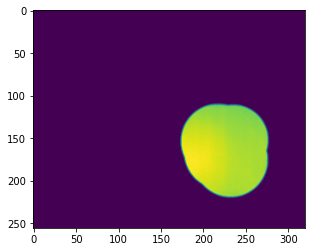

In [15]:
plt.imshow(reference_phantoms['560'][1][1])

In [16]:
stock_nigrosin_concentration_mg_ml = 0.8 #mg_ml

def get_mua_mus(sample_name,wavelength,water_volume=1000.,wv_delta=10):
    """
    calculate mua and mus in mm^{-1} using sample_name and central_wavelength
    """

    volume_nig,volume_lip = map(float,sample_name.split('_'))
    total_volume = volume_nig + volume_lip + water_volume
    
    conc_nig = stock_nigrosin_concentration_mg_ml*volume_nig/total_volume
    conc_lip = volume_lip/total_volume
    #print(conc_nig*1000,conc_lip*1000)
    mua = calibration.get_mua(conc_nig,central_wavelength=int(wavelength),delta=wv_delta)
    mus = calibration.get_mus(conc_lip,central_wavelength=int(wavelength),delta=wv_delta)/1.7
    return mua,mus

In [17]:
get_mua_mus('070_090','630')

(0.2903225570129321, 1.4463264601705537)

In [18]:
get_mua_mus('80_140','560')

(0.34353180055558374, 2.8042336768142753)

In [19]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle
from skimage.util import img_as_ubyte


In [20]:
def get_mask_for_phantom(binned_mac,verbose=True):
    mask = np.zeros_like(binned_mac[0],dtype=np.bool_)
    mask[100:300,100:300]= True
    
    image = binned_mac[0]
    edges = canny(image,mask=mask,use_quantiles=True)
    hough_radii = np.arange(40, 100, 5)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 3 circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=1)
    
    circle_mask = np.zeros_like(mask)
    
    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle(center_y, center_x, radius,
                                        shape=image.shape)
        circle_mask[circy,circx] = True
        
    if verbose:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(edges)
        plt.title('Find edges')
        
        plt.subplot(1,3,2)
        plt.imshow(circle_mask)
        plt.title("Found circle")
        
        plt.subplot(1,3,3)
        plt.imshow(mask&circle_mask)
        plt.title('Final mask')
        
    return mask&circle_mask

In [21]:
df=pd.read_pickle('/2tb_drive/old_data/notebooks/Kirill/modeling_results_SFDI_11_ext.pkl')

df.sort_values(by=['mua','mus'],inplace=True)
df['mua']=df['mua'].astype(float)
df['mus']=df['mus'].astype(float)/10
df_mcml=df.copy()

In [24]:
folders

['/2tb_drive/old_data/data/Hemoglobin/2022-06-08/040_100/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/100_140/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/060_080/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/050_130/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/080_140/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/070_090/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/090_110/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/030_090/560',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/040_100/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/100_140/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/060_080/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/050_130/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/080_140/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/070_090/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/090_110/630',
 '/2tb_drive/old_data/data/Hemoglobin/2022-06-08/030_09

In [26]:
folder_pat = '/2tb_drive/old_data/data/Hemoglobin/2022-08-03-sfdi/240/560'

In [40]:
processed=read_and_preprocess(folder_pat,binning_kernel_size=1)

In [58]:
count=0
for i in processed[1][1:]:
    img=i[200:-100,500:-100]/1024*255
    
    plt.imsave(f'/2tb_drive/old_data/data/Kirill/mac_gif/{count}.jpeg',img,cmap='gray',vmax=0.1)
    count+=1

In [59]:
filenames = sorted(glob.glob('/2tb_drive/old_data/data/Kirill/mac_gif/*'))
filenames

['/2tb_drive/old_data/data/Kirill/mac_gif/0.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/1.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/2.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/3.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/4.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/5.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/6.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/7.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/8.jpeg',
 '/2tb_drive/old_data/data/Kirill/mac_gif/9.jpeg']

In [60]:
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('/2tb_drive/old_data/data/Kirill/mac.gif', images,duration=0.5)

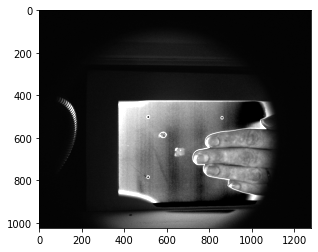

In [61]:
plt.imshow(processed[1][0],cmap='gray',vmax=0.2)

In [63]:
def calculate_diffuse_reflectance(spatial_frequencies,df=df, mua=1., mus_prime=10., refractive_index=1.37):
    """
    Calculate diffuse reflectance R(k) for given spatial frequencies
    in diffuse model approximation for given absorption coefficients mua,
    reduced scattering coefficient mus_prime and refractive_index

    Note that all parameters should be of the same physical dimension, i.e. mm^-1, or cm^-1

    :param spatial_frequencies: (list or 1d np.array) of spatial frequencies
    :param mua: (float) absorption coefficient, e.g. 1 mm^-1
    :param mus_prime: (float) reduced scattering, e.g. 10 mm^-1
    :param refractive_index: (float) refractive index of tissue (dimensionless)

    :return: (1d np.array) values of diffuse reflectance for given spatial_frequencies
    """
    #model = DiffuseModel(n=refractive_index)
    mus=mus_prime
    arg=df.apply(lambda x:((x['mua']-mua)**2)/mua+((x['mus']-mus)**2)/mus,axis=1).argmin()
    return df.iloc[arg].R_k
    #found_mua=df.iloc[(df['mua']-mua).abs().argsort()].mua.iloc[0]
    #found_mus=df[df.mua==found_mua].iloc[(df[df.mua==found_mua]['mus']-mus).abs().argsort()].mus.iloc[0]
    #return df[df.mua==found_mua][df.mus==found_mus].R_k.iloc[0]
    #return model.evaluate(spatial_frequencies, mua=mua, mus_prime=mus_prime)
    
def get_reflectance_stack(freqs_test, mac_test, freqs_reference, mac_reference, ref_mua=1.,
                          ref_mus_prime=10., refractive_index=1.37):
    """
    Calculate reflectance stack based on alternating component of transport function (Mac)
    of test sample and reference sample

    R(k,x,y) = R_ref(k)*Mac_test(k,x,y)/Mac_reference(k,x,y)

    :param freqs_test: (1d np.array) spatial frequencies for test object
    :param mac_test: (3d np.array of shape (len(freqs_test),Nx,Ny)) of  Mac values for different pixels of an image of test object
    :param freqs_reference: (1d np.array) spatial frequencies for reference object
    :param mac_reference: (3d np.array of shape (len(freqs_test),Nx,Ny)) of  Mac values for different pixels of an image of test object
    :param ref_mua: absorption coefficient of reference object
    :param ref_mus_prime: reduced scattering coefficient of reference object
    :param refractive_index: refractive index of reference object
    :return: reflectance 3d np.array stack of shape (len(freqs_test),Nx,Ny) of diffuse reflectance values
    """

    mac_reference_for_freqs = {f: mac for f, mac in zip(freqs_reference, mac_reference)}
    reference_diffuse_reflectance = calculate_diffuse_reflectance(freqs_test, mua=ref_mua,
                                                                  mus_prime=ref_mus_prime,
                                                                  refractive_index=refractive_index)

    mac_reference_reshape = np.stack([mac_reference_for_freqs[f] for f in freqs_test])
    return mac_test * reference_diffuse_reflectance.reshape(-1, 1, 1) / mac_reference_reshape

In [64]:
#freqs=np.array([1,2,4,6,10,12,14,22,26,34,36,40,44])

In [65]:
rs = {}

In [66]:
#diffuse_model = fitter.DiffuseModel()
results = {}

verbose = False
for sample_folder in folders[:]:
    sample_name = get_sample_name(sample_folder)
    wavelength = get_wavelength(sample_folder)
    
    name = f'{sample_name}_wv={wavelength}'
    if name in rs:
        continue
    #calculating reference absorption and scattering for reference phantom
    ref_freqs,ref_binned_mac = reference_phantoms[wavelength]
    
    print(f'Fitting {name}')
   # read and preprocessing the input sample
    test_freqs, mac = read_and_preprocess(sample_folder=sample_folder,
                                              binning_kernel_size=9,
                                              verbose=verbose)
    
# 
#     except ValueError:
#         print(f"Something went wrong when reading {sample_folder}")
#         mac_2 = mac_1.copy()
    
    binned_mac = mac#[name]
    
    spatial_frequencies = calculate_real_frequencies_from_prepends(test_freqs)
    spatial_frequencies_ref = calculate_real_frequencies_from_prepends(ref_freqs)
    
    mua_ref,mus_ref = get_mua_mus(reference_phantom_name,wavelength)
    
    reflectance_stack = get_reflectance_stack(freqs_test=spatial_frequencies,
                          mac_test=binned_mac,
                          freqs_reference=spatial_frequencies_ref,
                          mac_reference=ref_binned_mac,
                                             ref_mua=mua_ref,
                                             ref_mus_prime=mus_ref)
    
    
    
    #print('Spatial frequencies in mm^{-1} are',spatial_frequencies)
    
    _vmin = 0.01 #np.percentile(reflectance_stack[:,phantom_mask].ravel(),1)
    _vmax = 0.8 #np.percentile(reflectance_stack[:,phantom_mask].ravel(),99)
    
    
    ref_mask  = get_mask_for_phantom(ref_binned_mac,verbose=False)
    test_mask = get_mask_for_phantom(binned_mac,verbose=False)
    fit_mask = skmorph.erosion(ref_mask&test_mask,selem=np.ones((11,11)))
    
    
    reflectance_stack[:,~fit_mask] = np.nan
    
    if verbose:
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(ref_mask)
        plt.title("Reference mask")

        plt.subplot(1,3,2)
        plt.imshow(test_mask)
        plt.title("Test mask")

        plt.subplot(1,3,3)
        plt.imshow(fit_mask)
        plt.title('Fit mask = RefMask x TestMask')


        plt.figure(figsize=(8,5))
        plt.plot(spatial_frequencies,np.mean(reflectance_stack[:,fit_mask],axis=1))
        plt.xlabel("Spatial frequency, mm^{-1}")
        plt.ylabel("Mean reflectance")
        for i,r in enumerate(reflectance_stack):
            if i%5 == 0:
                plt.figure(figsize=(20,4))

            plt.subplot(1,5,i%5 + 1)
            plt.imshow(r,vmin=_vmin,vmax=_vmax)
            plt.title(f'Spatial frequency\nk ={spatial_frequencies[i]:.2f}' + r', $\rm mm^{-1}$')

            plt.colorbar()

            if i%5 == 4 or i == reflectance_stack.shape[0]-1:
                plt.show()
                plt.tight_layout()
    
    
#     fit_results = fitter.fit_diffuse_reflectance_stack(spatial_frequencies,reflectance_stack,
#                                   fit_mask=fit_mask,diffuse_model=diffuse_model,backend='cpp')
    
#     results[name] = fit_results
    rs[name] = spatial_frequencies,reflectance_stack

Fitting 040_100_wv=560


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19


Fitting 100_140_wv=560


KeyboardInterrupt: 

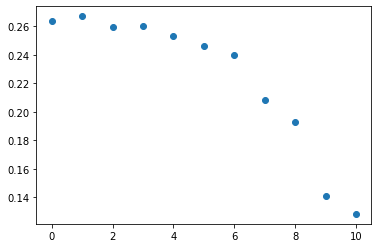

In [97]:
plt.plot(rs['040_100_wv=560'][1][:,170:180,235:245].mean(axis=(1,2)),'o')

In [91]:
(rs['040_100_wv=560'][1]).shape

(11, 256, 320)

In [145]:
to_fit = rs['040_100_wv=560'][1][:,170:180,235:245].mean(axis=(1,2))

In [150]:
rs['040_100_wv=560'][1][:,170:180,235:245].T.shape

(10, 10, 11)

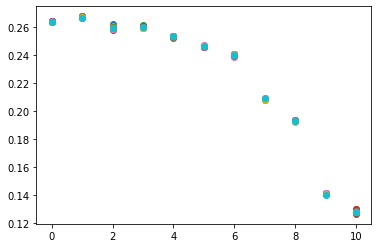

In [157]:
for i in rs['040_100_wv=560'][1][:,170:180,235:245].mean(axis=(2)).T:
    plt.plot(i,'o')
                  
      

In [99]:
to_fit.shape

(11,)

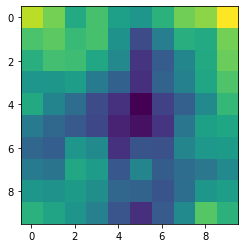

In [100]:
plt.imshow(rs['040_100_wv=560'][1][2][170:180,235:245])

In [101]:
import pickle as pkl

In [102]:
with open('/2tb_drive/old_data/notebooks/Kirill/knn_mua_11.pkl','rb') as f:
    regressor_mua = pkl.load(f)

with open('/2tb_drive/old_data/notebooks/Kirill/knn_mus_11.pkl','rb') as f:
    regressor_mus = pkl.load(f)
     
with open('/2tb_drive/old_data/notebooks/Kirill/knn_scaler_11.pkl','rb') as f:
    knn_scaler = pkl.load(f)

In [103]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=1000)

In [115]:
fit = knn_scaler.transform([to_fit])
mua = regressor_mua.predict(fit)[0][0]
mus = regressor_mus.predict(fit)[0][0]

In [119]:
arg=df.apply(lambda x:((x['mua']-mua)**2)/mua+((x['mus']-mus)**2)/mus,axis=1).argmin()
R_k = df.iloc[arg].R_k

In [128]:
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
 
# Dataset
x = spatial_frequencies
y = R_k
 
X_Y_Spline = make_interp_spline(x, y)
 
# Returns evenly spaced numbers
# over a specified interval.
X_ = np.linspace(x.min(), x.max(), 500)
Y_ = X_Y_Spline(X_)

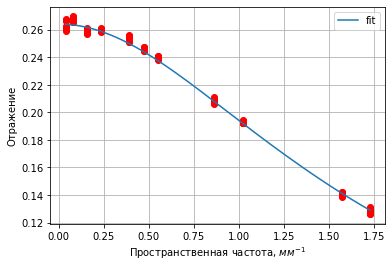

In [168]:
plt.plot(spatial_frequencies,to_fit,'o',color='r')
plt.plot(X_,Y_,label='fit')
plt.ylabel('Отражение')
plt.xlabel('Пространственная частота, $мм^{-1}$ ')
plt.grid()
plt.legend()


In [70]:

results={}
for i in rs:
    print(i)
    fit_result={}
    reflectance_stack=rs[i][1]
    f,h,w=reflectance_stack.shape
    fit = np.stack(reflectance_stack,-1).reshape(h*w,f)
    fit = knn_scaler.transform(fit)
    fit = imp.fit_transform(fit)
    fit_result['mua'] =regressor_mua.predict(fit).reshape(h,w)
    fit_result['mus'] =regressor_mus.predict(fit).reshape(h,w)
    
    results[i] = fit_result

040_100_wv=560
100_140_wv=560
060_080_wv=560
050_130_wv=560
080_140_wv=560
070_090_wv=560
090_110_wv=560
030_090_wv=560
040_100_wv=630
100_140_wv=630
060_080_wv=630
050_130_wv=630
080_140_wv=630
070_090_wv=630
090_110_wv=630
030_090_wv=630
030_090_3_wv=560
030_090_2_wv=560
030_090_1_wv=560
040_100_2_wv=560
040_100_1_wv=560
040_100_3_wv=560
030_090_3_wv=630
030_090_2_wv=630
030_090_1_wv=630
040_100_2_wv=630
040_100_1_wv=630
040_100_3_wv=630


In [88]:
len(rs)

28

In [89]:
keys=list(results.keys())
mua1=results[keys[0]]['mua']
mua2=results['080_140_wv=560']['mua']

In [90]:
from scipy.stats import mode
def get_mask_without_outliers(mua):
    #mean=mua.mean()
    mask  = mua!=mode(mua).mode[0][0]#(mua<0.98*mean) | (mua>1.02*mean)
    return skmorph.binary_erosion(mask,selem=np.ones((13,13)))

def get_percentile_limits(mua,mask=None,low=5,high=95):
    if mask is None:
        mask = np.ones(mua.shape,dtype=np.bool_)
    
    return np.percentile(mua[mask],low),np.percentile(mua[mask],high)

040_100_wv=560


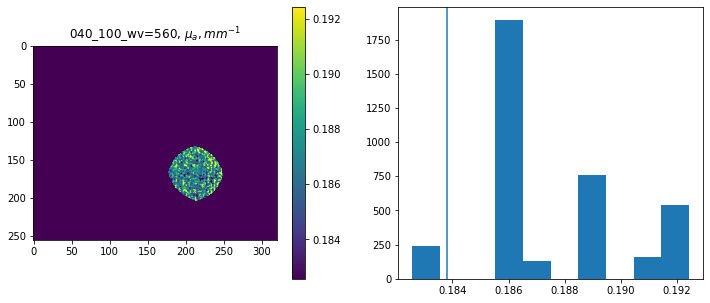

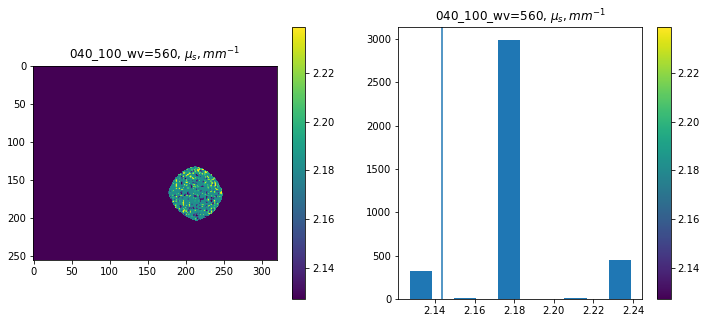

100_140_wv=560


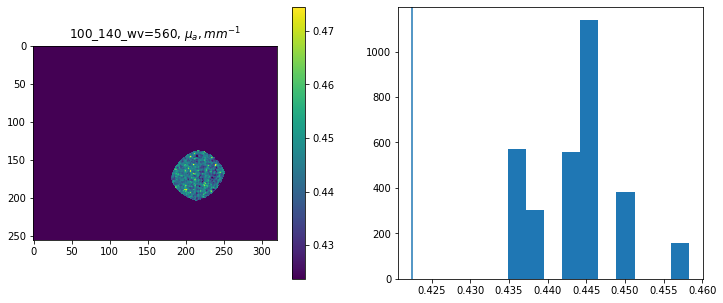

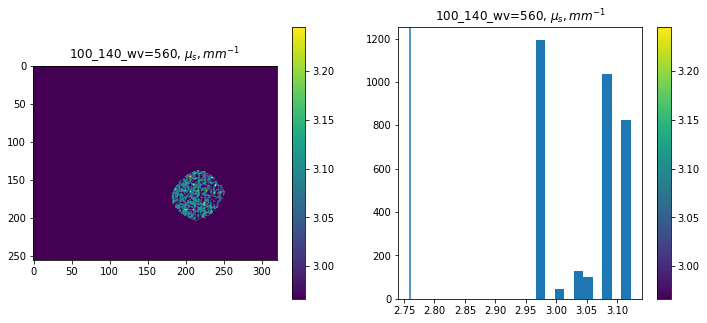

060_080_wv=560


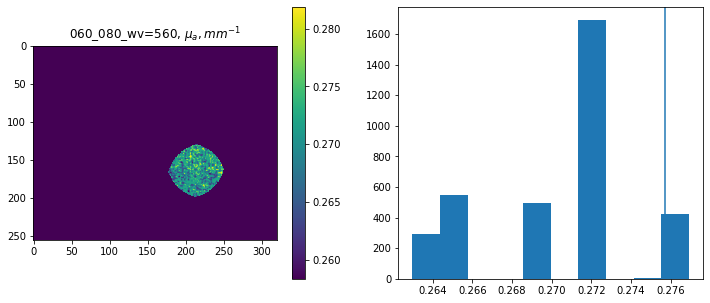

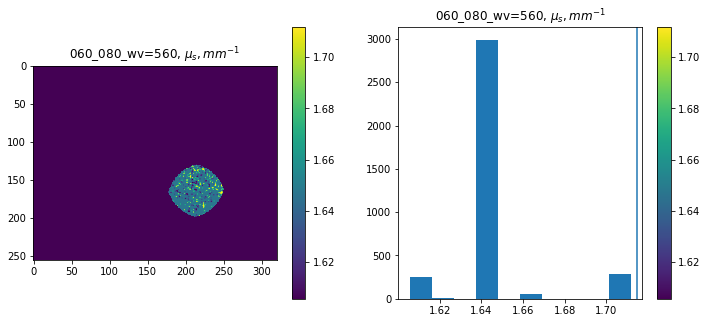

050_130_wv=560


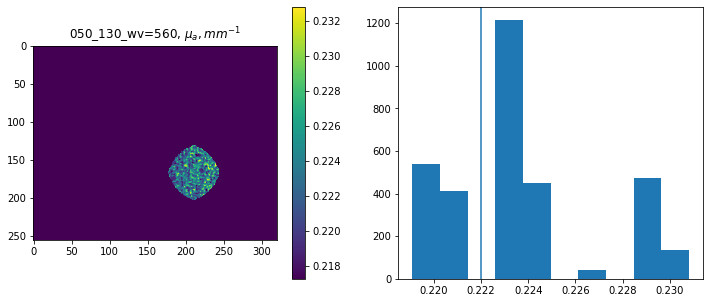

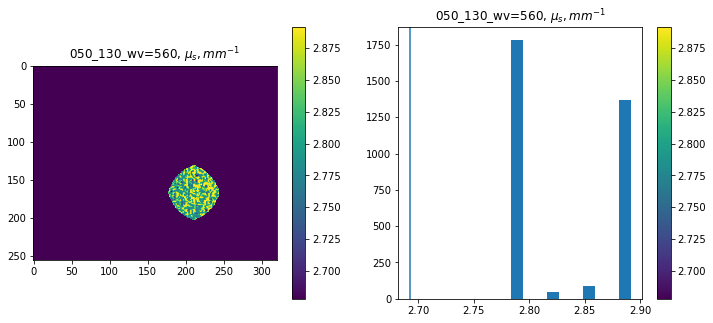

080_140_wv=560


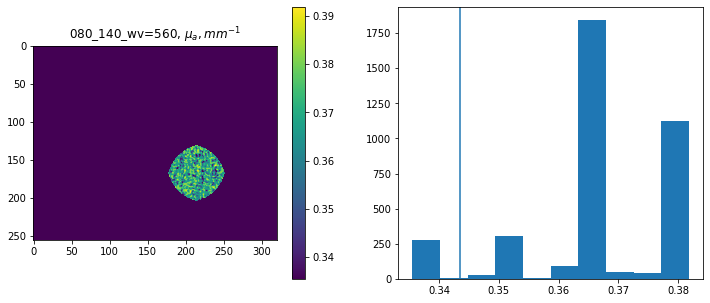

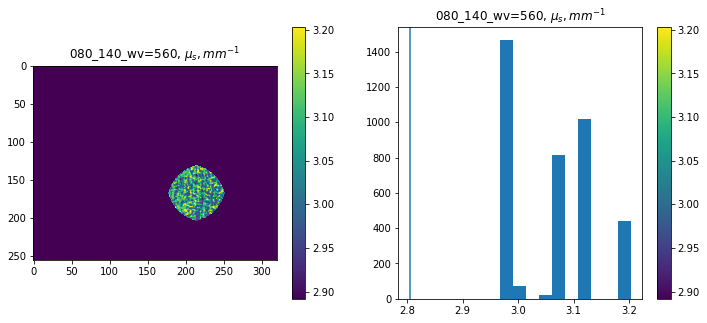

070_090_wv=560


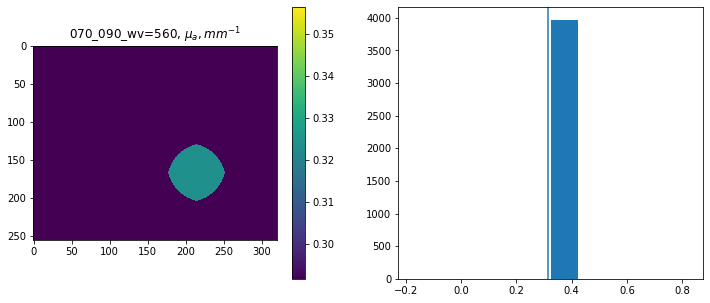

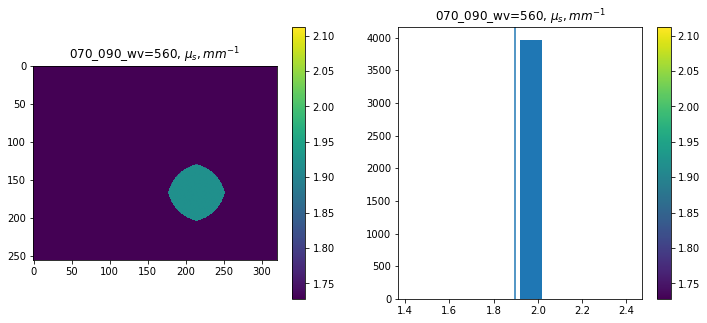

090_110_wv=560


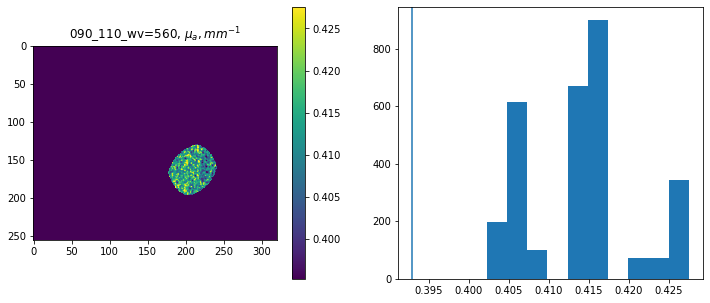

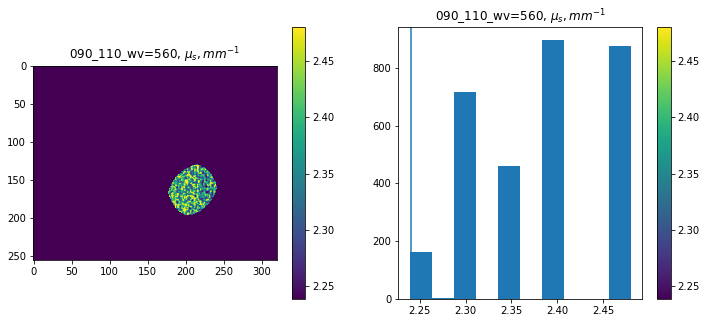

030_090_wv=560


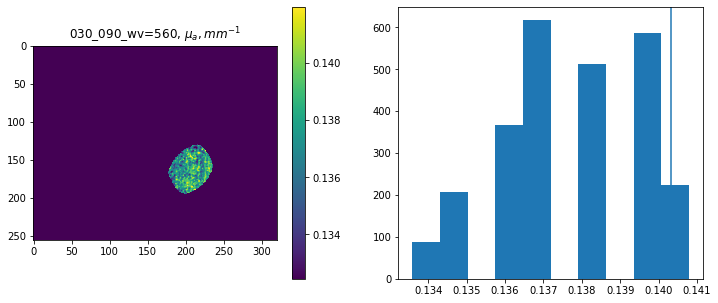

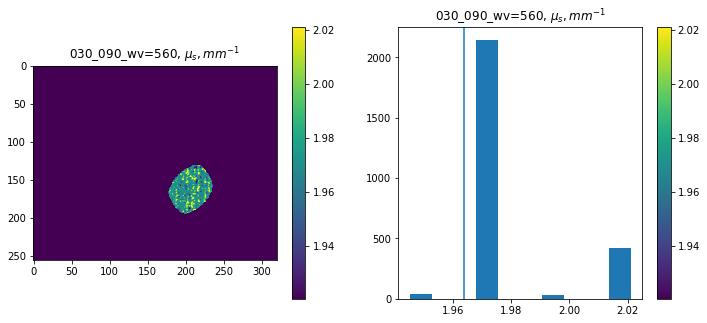

040_100_wv=630


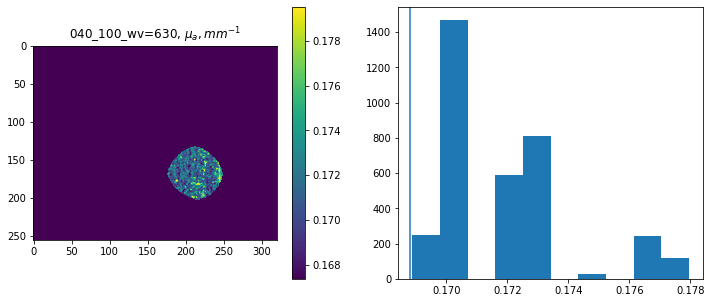

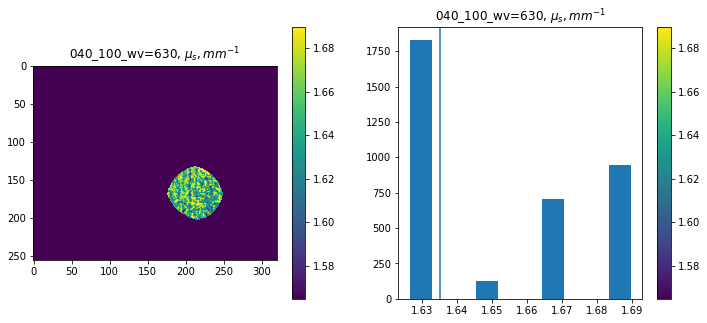

100_140_wv=630


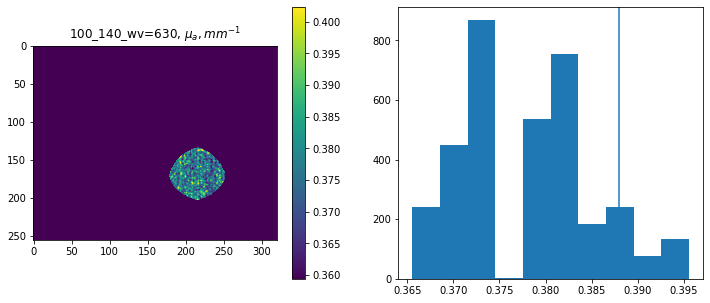

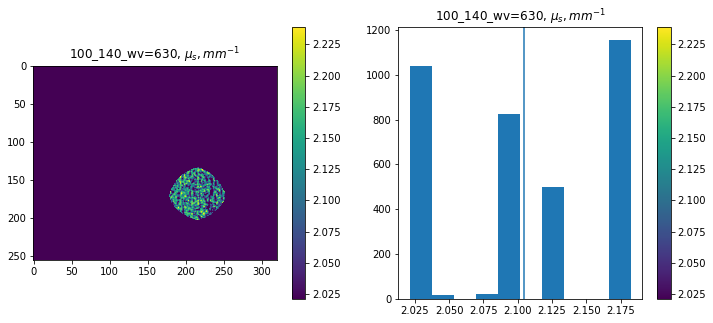

060_080_wv=630


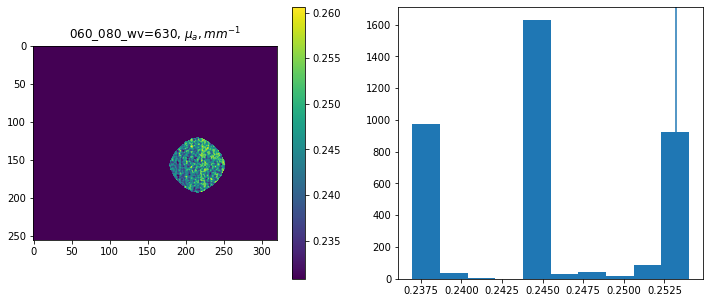

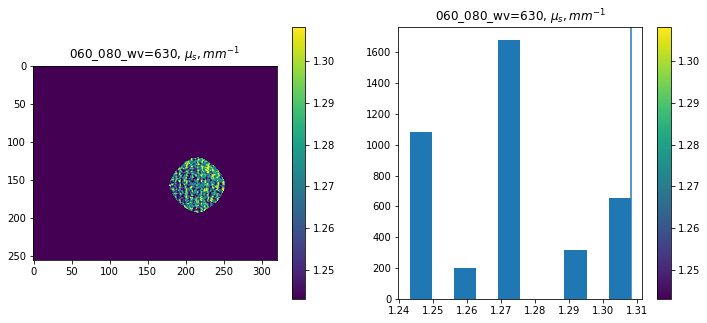

050_130_wv=630


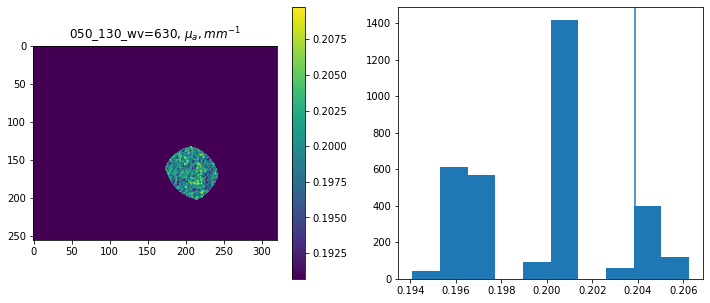

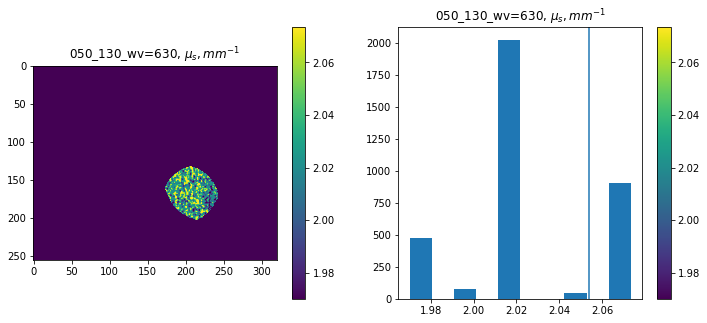

080_140_wv=630


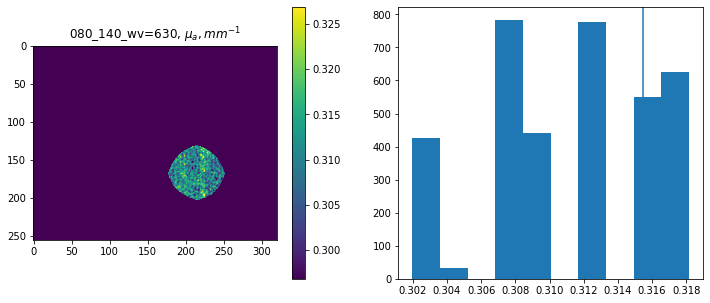

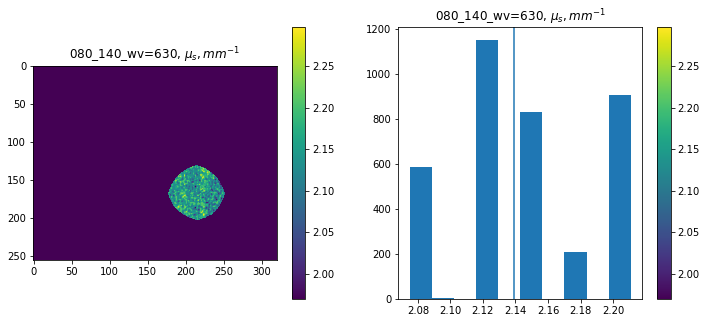

070_090_wv=630


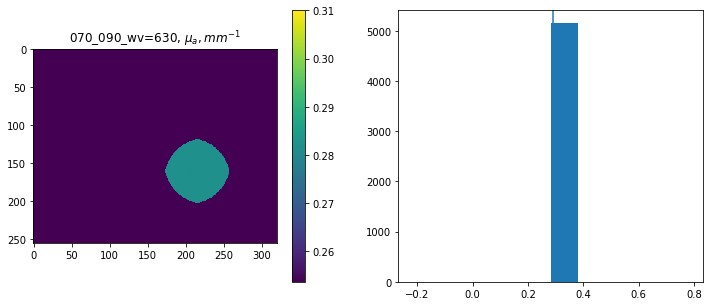

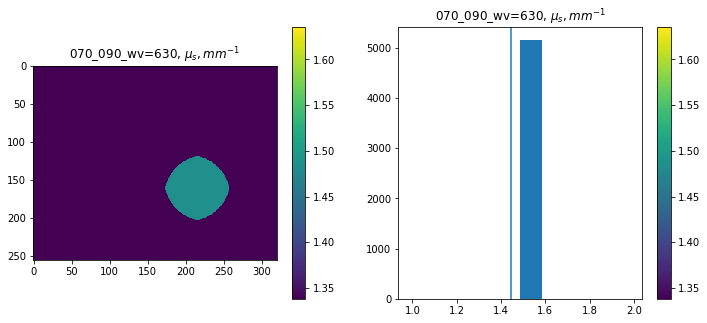

090_110_wv=630


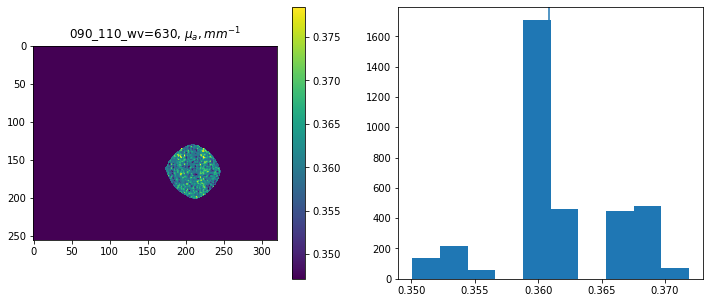

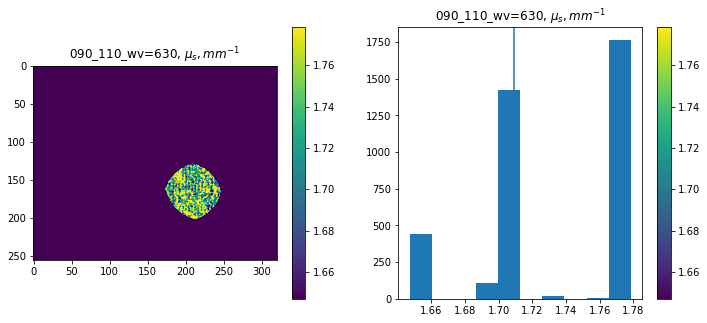

030_090_wv=630


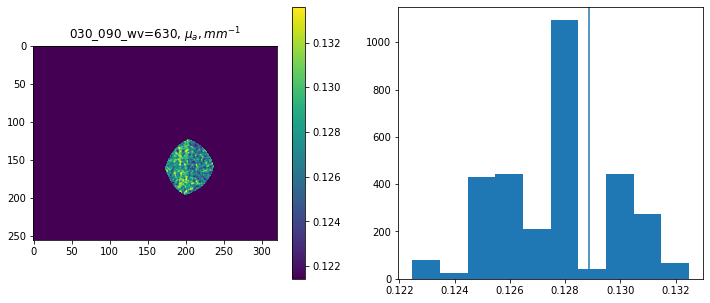

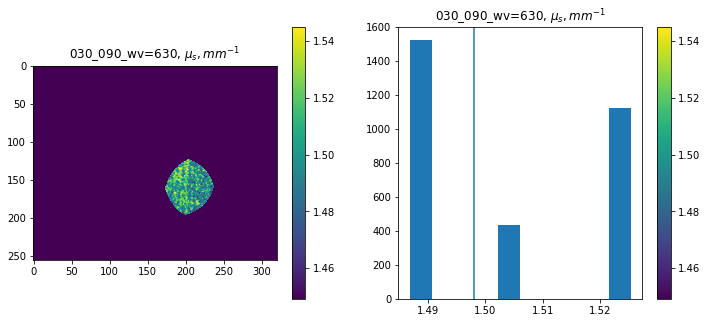

030_090_3_wv=560


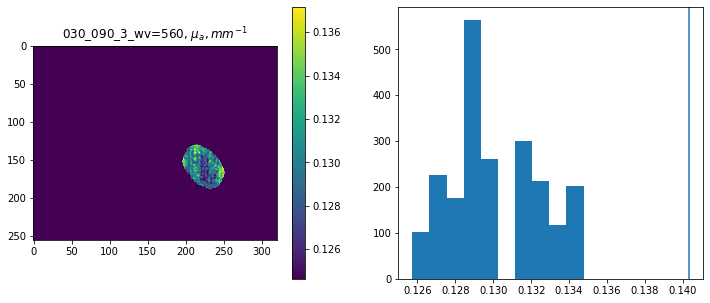

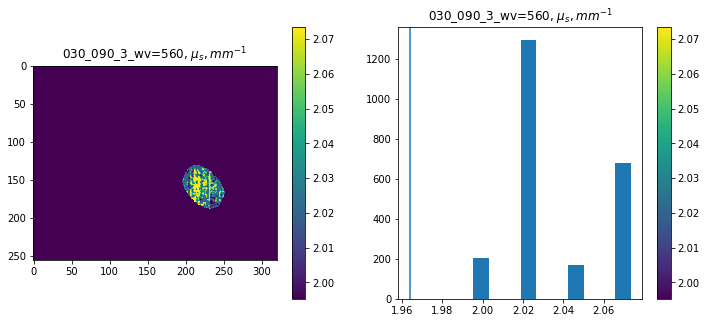

030_090_2_wv=560


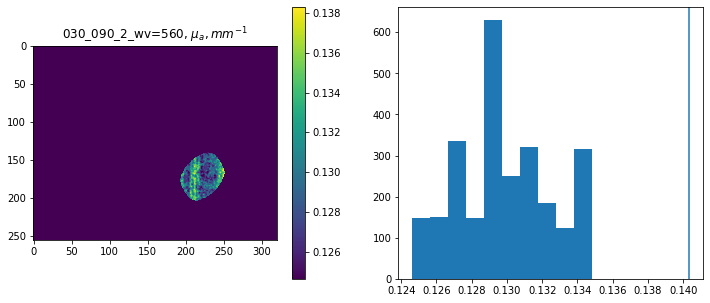

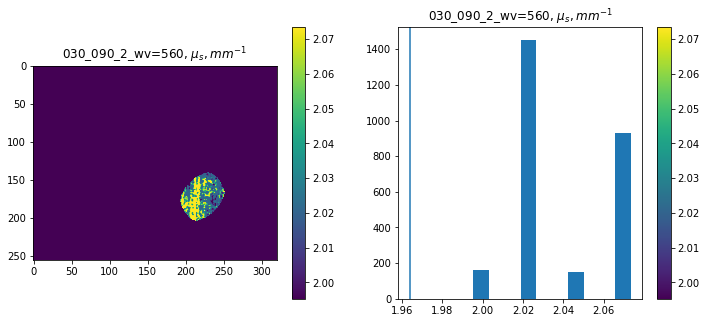

030_090_1_wv=560


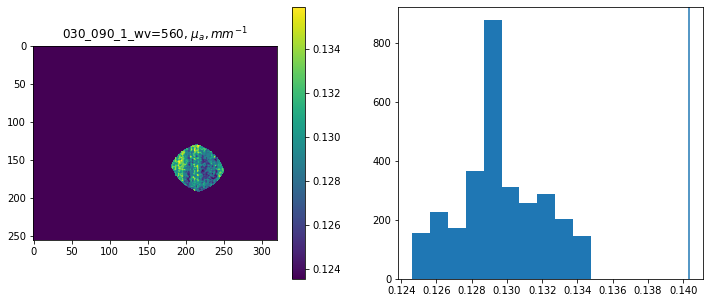

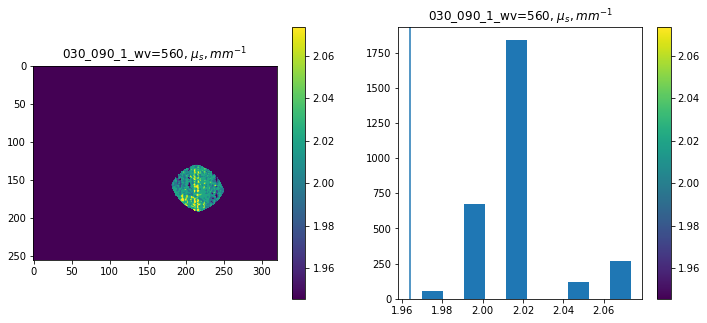

040_100_2_wv=560


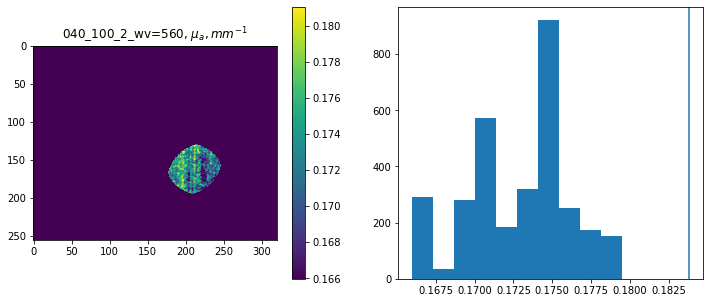

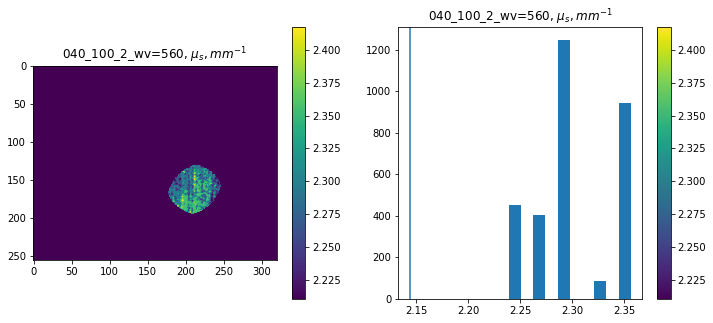

040_100_1_wv=560


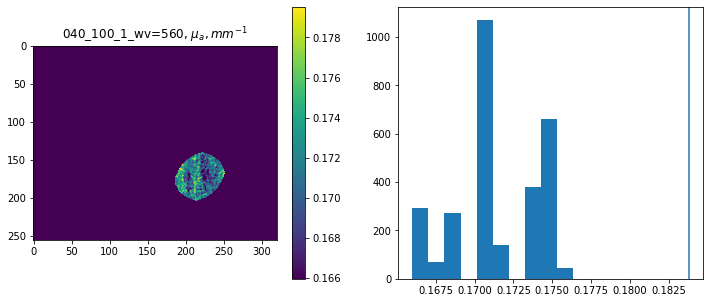

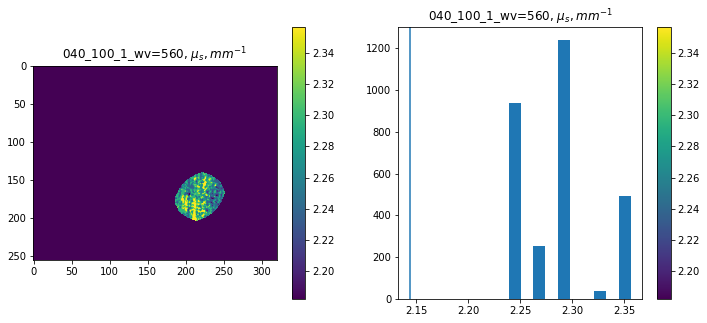

040_100_3_wv=560


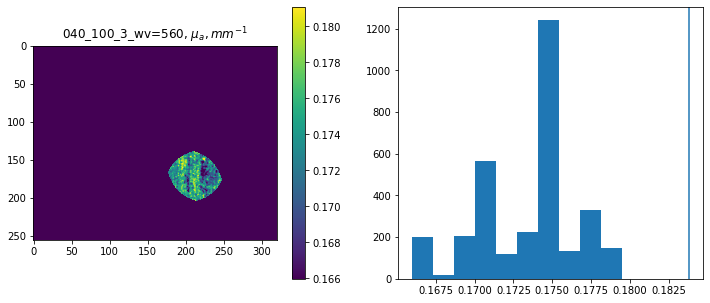

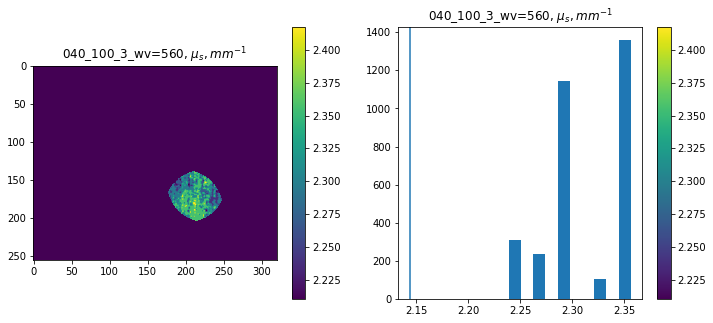

030_090_3_wv=630


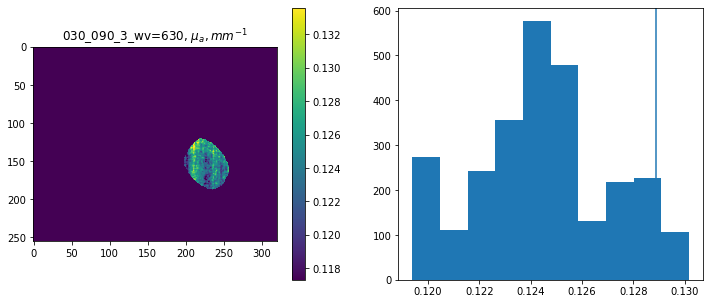

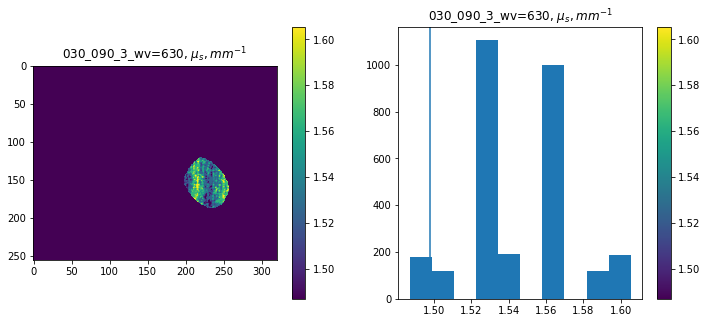

030_090_2_wv=630


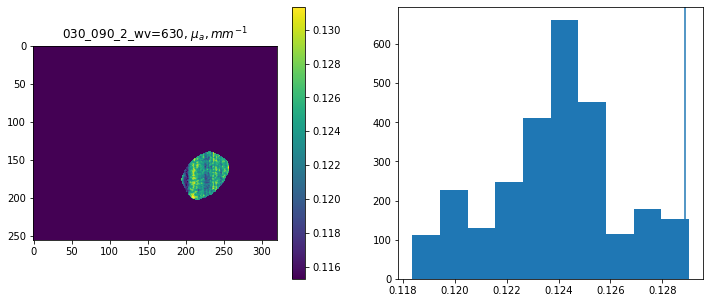

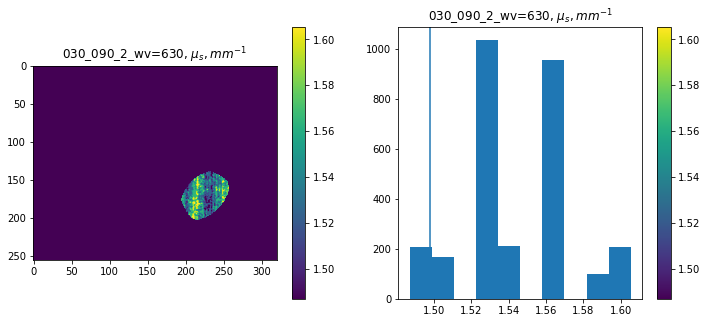

030_090_1_wv=630


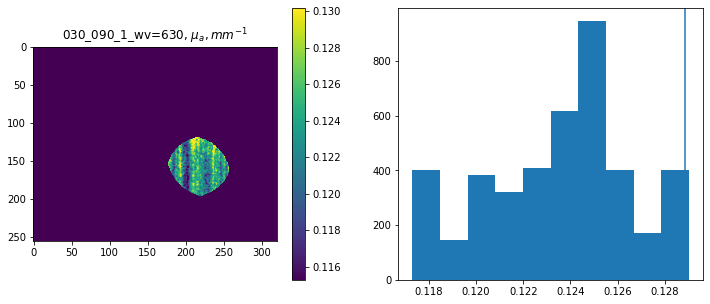

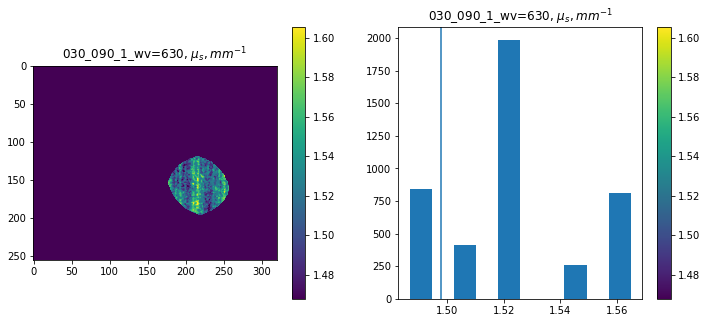

040_100_2_wv=630


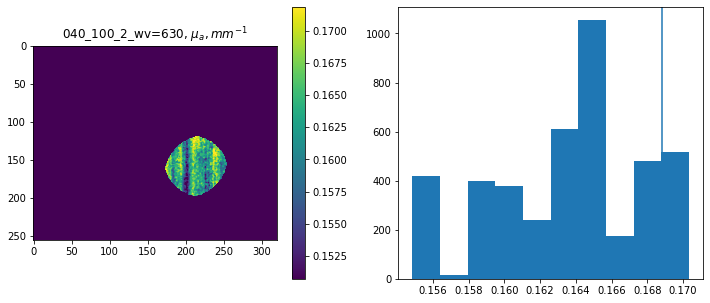

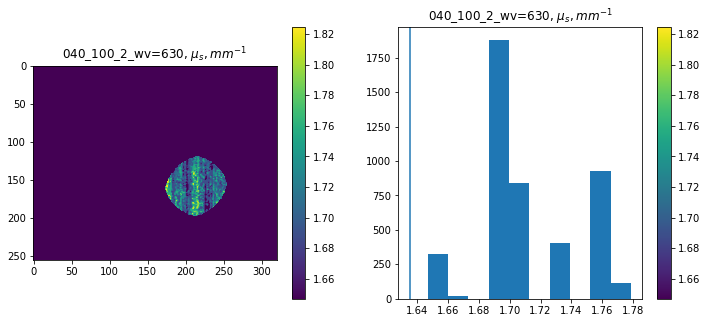

040_100_1_wv=630


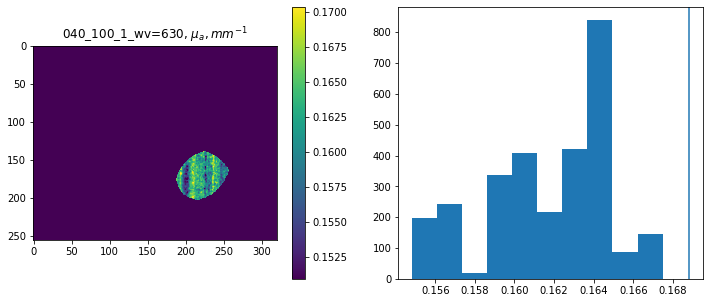

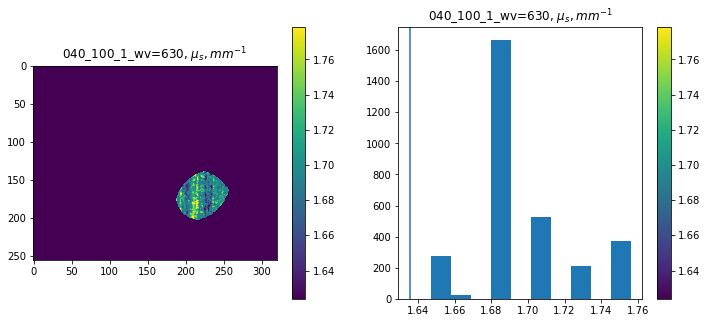

040_100_3_wv=630


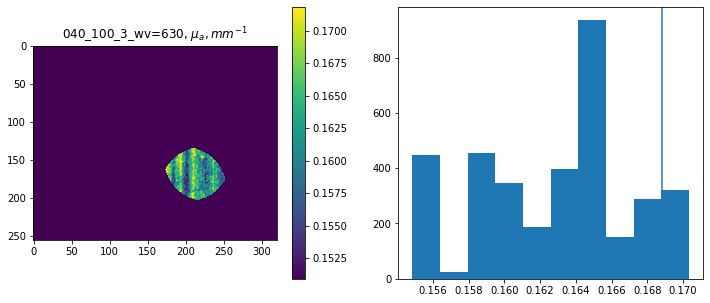

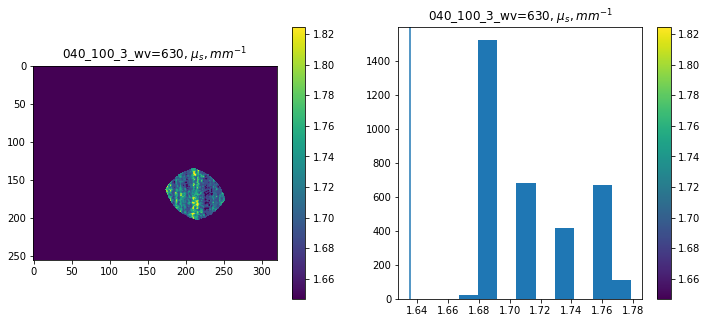

In [91]:

for name, result in results.items():
    print(name)
    mua = result['mua'].copy()
    mus = result['mus'].copy()
    
    mask = get_mask_without_outliers(mua)
    mua[~mask] = 0
    mus[~mask] = 0

    sample_name = '_'.join(name.split('_')[:2])
    wavelength = name.split('=')[-1]
    
    true_mua,true_mus = get_mua_mus(sample_name,wavelength)
    
    spatial_frequencies,reflectance = rs[name]
    
#     plt.figure(figsize=(8,5))
#     r = reflectance[3].copy()
#     r[~mask] = np.nan
#     plt.imshow(r,vmin=0.25,vmax=0.3)
#     plt.show()
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)

    vmin,vmax = get_percentile_limits(mua,mask,low=1,high=99)
    plt.imshow(mua,vmin=vmin,vmax=vmax)
    plt.title(f'{name}, ' + r'$\mu_a, mm^{-1}$')

    plt.colorbar()
    plt.subplot(1,2,2)
    vmin,vmax = get_percentile_limits(mua,mask)
    plt.hist(mua[mask],range=(vmin,vmax))
    plt.axvline(true_mua)
    
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)

    vmin,vmax = get_percentile_limits(mus,mask,low=1,high=99)
    plt.imshow(mus,vmin=vmin,vmax=vmax)
    plt.title(f'{name}, ' + r'$\mu_s, mm^{-1}$')

    plt.colorbar()
    plt.subplot(1,2,2)
    vmin,vmax = get_percentile_limits(mus,mask)
    plt.hist(mus[mask],range=(vmin,vmax))
    plt.axvline(true_mus)
    
    plt.title(f'{name}, ' + r'$\mu_s, mm^{-1}$')
    
    
    
    plt.colorbar()
    plt.show()
    
#     xx,yy = np.indices(reflectance.shape[1:])
#     ids = np.arange(xx[mask].shape[0])
#     random_ids = np.random.choice(ids,size=20,replace=False)
#     _xs,_ys = xx[mask][random_ids],yy[mask][random_ids]
    
#     for _x,_y in zip(_xs,_ys):
#         y_true = reflectance[:,_x,_y]
        
#         a,s = mua[_x,_y],mus[_x,_y]
#         plt.figure(figsize=(15,5))
#         plt.subplot(1,3,1)
#         y_pred = diffuse_model.evaluate(spatial_frequencies,mua=a,mus_prime=s)
#         plt.plot(spatial_frequencies,y_true,'ro')
    
#         plt.plot(spatial_frequencies,y_pred)
        
#         plt.xlabel(r"Spatial frequency,$\rm mm^{-1}$")
#         plt.ylabel("Diffuse reflectance R(k)")
    
#         plt.subplot(1,3,2)
#         plt.plot(spatial_frequencies,y_true-y_pred)
#         plt.xlabel(r"Spatial frequency,$\rm mm^{-1}$")
#         plt.ylabel("Residuals")
#         plt.axhline(0.,linestyle='dashed')
        
#         plt.subplot(1,3,3)
#         plt.hist(y_true-y_pred)
#         plt.axvline(0.)
        
#         plt.tight_layout()
        
        
#         plt.show()
    
    

In [113]:
fit_df = {k:[] for k in ['mua','mus','name']}

for name, result in results.items():
    print(name)
    #plt.figure(figsize=(12,10))
    mua = result['mua'].copy()
    mus = result['mus'].copy()
    
    mask = get_mask_without_outliers(mua)
    
    
    low_a,high_a = get_percentile_limits(mua,mask)
    low_s,high_s = get_percentile_limits(mus,mask)
    mask = mask&(mua>low_a)&(mua<high_a)&(mus>low_s)&(mus<high_s)
    
    for i,par in enumerate(['mua','mus']):
        values = result[par][mask]
        
        fit_df[par].extend(values.tolist())
        
        _title = par# if i != 1 else f'{name}\n{par}'
        
    fit_df['name'].extend([name]*np.sum(mask))
        
    #plt.show()
df = pd.DataFrame(fit_df)

040_100_wv=560
100_140_wv=560
060_080_wv=560
050_130_wv=560
080_140_wv=560
070_090_wv=560
090_110_wv=560
030_090_wv=560
040_100_wv=630
100_140_wv=630
060_080_wv=630
050_130_wv=630
080_140_wv=630
070_090_wv=630
090_110_wv=630
030_090_wv=630
030_090_3_wv=560
030_090_2_wv=560
030_090_1_wv=560
040_100_2_wv=560
040_100_1_wv=560
040_100_3_wv=560
030_090_3_wv=630
030_090_2_wv=630
030_090_1_wv=630
040_100_2_wv=630
040_100_1_wv=630
040_100_3_wv=630


In [98]:
df['wavelength'] = df['name'].apply(lambda x: x.split('=')[1])
df['sample_name'] = df['name'].apply(lambda name:"_".join(name.split("_")[:2]))

In [114]:
df.name.unique()

array(['040_100_wv=560', '100_140_wv=560', '060_080_wv=560',
       '050_130_wv=560', '080_140_wv=560', '090_110_wv=560',
       '030_090_wv=560', '040_100_wv=630', '100_140_wv=630',
       '060_080_wv=630', '050_130_wv=630', '080_140_wv=630',
       '090_110_wv=630', '030_090_wv=630', '030_090_3_wv=560',
       '030_090_2_wv=560', '030_090_1_wv=560', '040_100_2_wv=560',
       '040_100_1_wv=560', '040_100_3_wv=560', '030_090_3_wv=630',
       '030_090_2_wv=630', '030_090_1_wv=630', '040_100_2_wv=630',
       '040_100_1_wv=630', '040_100_3_wv=630'], dtype=object)

In [115]:
def get_wv_from_name(name):
    return name.split('=')[-1]

In [116]:
for name in df['name'].unique():
    wavelength = get_wv_from_name(name)
    sample_name = '_'.join(name.split('_')[:2])
    df.loc[df['name'] == name,'true_mua'] = get_mua_mus(sample_name,wavelength=int(wavelength))[0]

In [117]:
for name in df['name'].unique():
    wavelength = get_wv_from_name(name)
    sample_name = '_'.join(name.split('_')[:2])
    df.loc[df['name'] == name,'true_mus'] = get_mua_mus(sample_name,wavelength=int(wavelength))[1]

In [140]:
(abs(df['mus']-df['true_mus'])/df['true_mus']).mean()

0.035138518772308266

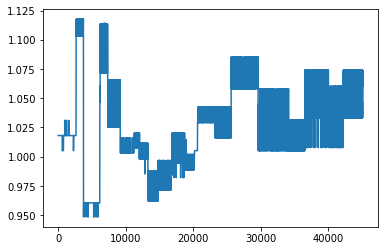

In [118]:
plt.plot(df['mus']/df['true_mus'])

In [129]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

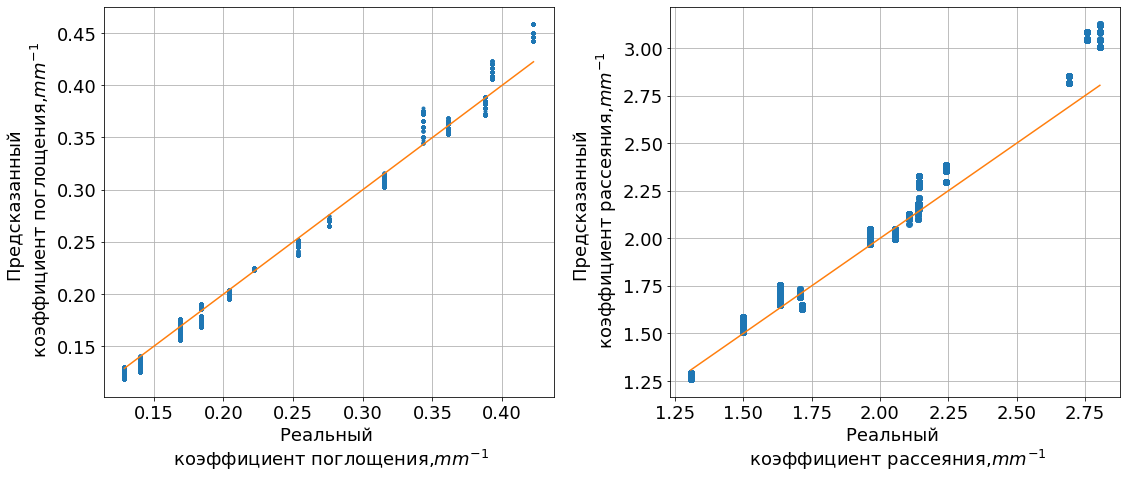

In [131]:
#df=df[df.wavelength=='560']
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.plot(df['true_mua'],df['mua'],'.')

_refs = np.linspace(df.true_mua.min(),df.true_mua.max())
plt.plot(_refs,_refs)
plt.grid()
plt.xlabel('Реальный \n коэффициент поглощения,$mm^{-1}$')
plt.ylabel('Предсказанный \n коэффициент поглощения,$mm^{-1}$')

plt.subplot(1,2,2)
plt.plot(df['true_mus'],df['mus'],'o')

_refs = np.linspace(df.true_mus.min(),df.true_mus.max())
plt.plot(_refs,_refs)

plt.grid()
plt.xlabel('Реальный \n коэффициент рассеяния,$mm^{-1}$')
plt.ylabel('Предсказанный \n коэффициент рассеяния,$mm^{-1}$')

plt.tight_layout()